In [11]:
import os
import cv2
import shutil
import numpy as np

In [29]:
import nbimporter
from monster_dataset import CanDataset, transform
from torch.utils.data import DataLoader, Dataset

In [30]:
train_dataset = CanDataset(root_dir='/home/mozy/Desktop/MonsterNana/Monster_energy_drink/train', transform=transform)
test_dataset = CanDataset(root_dir='/home/mozy/Desktop/MonsterNana/Monster_energy_drink/test', transform=transform)

# Crea i dataloader per il dataset di train e test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import torch
import torch.nn as nn

# Definisci il dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica il modello pre-addestrato ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modifica l'ultimo layer per adattarlo al numero di classi del dataset
num_features = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes) # model.fc è l'ultimo layer fully connected della ResNet

# Sposta il modello sul dispositivo
model = model.to(device)

# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss() # Loss function adatta ai problemi di classificazione multi-classe.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the list to store loss values
loss_values = []

# Funzione per addestrare il modello
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Azzerare i gradienti
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass e ottimizzazione
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Salva i valori di perdita in un file
    metrics = {
        'loss_values': loss_values,
        'num_epochs': 15,
        'learning_rate': 0.001,
        'optimizer_state_dict': optimizer.state_dict(),
        'model_state_dict': model.state_dict()
    }
    torch.save(metrics, 'model_metrics.pth')

# Addestra il modello e ottieni i valori di perdita
train_model(model, train_loader, criterion, optimizer, num_epochs=15)

/home/mozy/Desktop/monster/lib/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15, Loss: 1.2722
Epoch 2/15, Loss: 0.7269
Epoch 3/15, Loss: 0.5720
Epoch 4/15, Loss: 0.3706
Epoch 5/15, Loss: 0.3043
Epoch 6/15, Loss: 0.3115
Epoch 7/15, Loss: 0.2044
Epoch 8/15, Loss: 0.1823
Epoch 9/15, Loss: 0.1659
Epoch 10/15, Loss: 0.2220
Epoch 11/15, Loss: 0.2210
Epoch 12/15, Loss: 0.3104
Epoch 13/15, Loss: 0.1435
Epoch 14/15, Loss: 0.1198
Epoch 15/15, Loss: 0.1848


In [16]:
#CELLA DI CONTROLLO
metrics = torch.load('model_metrics.pth')
loss_values = metrics['loss_values']
print("Loss values:", loss_values)
print("Numero di valori:", len(loss_values))

Loss values: [1.3248570741609085, 0.6730748664501102, 0.4922781742589418, 0.4645900702060655, 0.36582841862772786, 0.28525340227886686, 0.21034467783431673, 0.2330035750082759, 0.17914541854068292, 0.277994503938528, 0.15970581987612817, 0.1343204239166753, 0.23851327697724797, 0.19270226831526258, 0.13913771739706052]
Numero di valori: 15


/tmp/ipykernel_40289/1050678345.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics = torch.load('model_metrics.pth')


/tmp/ipykernel_40289/1588597469.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics = torch.load('model_metrics.pth')


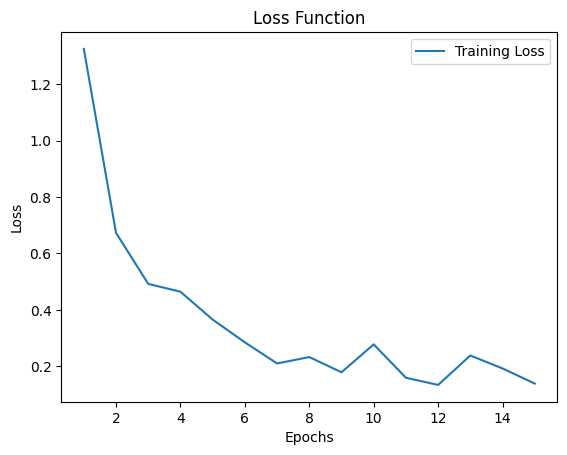

In [15]:
import torch

import matplotlib.pyplot as plt

# Carica i dati dal file
metrics = torch.load('model_metrics.pth')

# Estrai i valori di perdita e il numero di epoche
loss_values = metrics['loss_values']
num_epochs = metrics['num_epochs']

# Crea l'asse x con il numero di epoche
epochs = range(1, num_epochs + 1)

# Plot dei valori di perdita
plt.plot(epochs, loss_values[:num_epochs], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.legend()
plt.show()

In [17]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    test_loss = test_loss / len(test_loader)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Load the model state dict from the saved metrics
model.load_state_dict(metrics['model_state_dict'])

# Evaluate the model on the test dataset
evaluate_model(model, test_loader, criterion)

/home/mozy/Desktop/monster/lib/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Loss: 0.2840, Test Accuracy: 92.41%


/home/mozy/Desktop/monster/lib/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


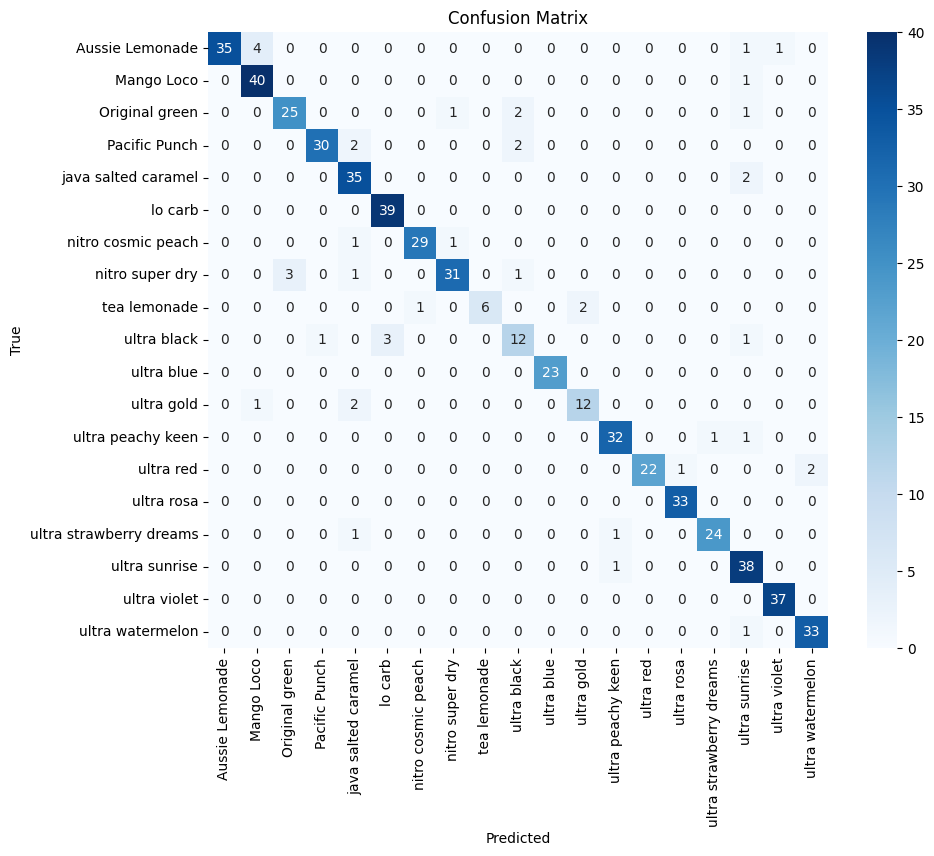

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, train_dataset.classes)